# RNN on a Time Series

## Imports

In [10]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Load the dataset

In [3]:
df = pd.read_csv('Alcohol_Sales.csv',index_col=0,parse_dates=True)
len(df)

325

In [4]:
# Always a good idea with time series data:
df.dropna(inplace=True)
len(df)

325

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [6]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>
Alternatively you could set your own limits with <tt>plt.xlim(pd.Timestamp('1992-01-01'), pd.Timestamp('2019-01-01'))</tt> or some other values.

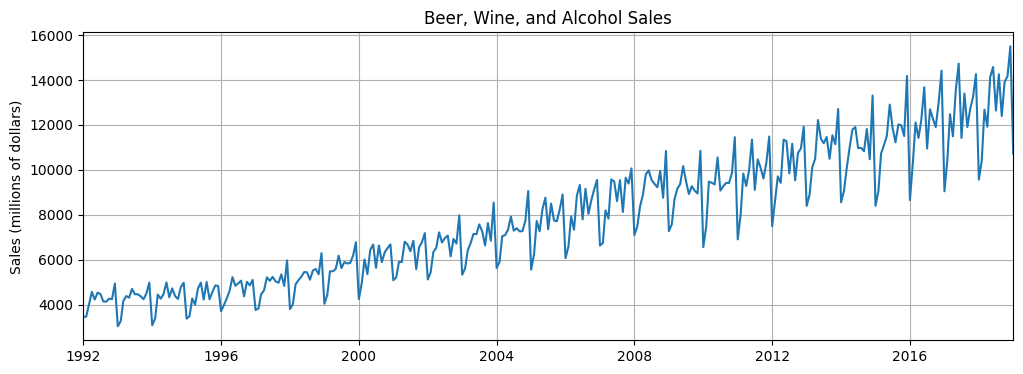

In [7]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [8]:
# Extract values from the source .csv file
y = df['S4248SM144NCEN'].values.astype(float)

# Define a test size
test_size = 12

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [9]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

## Normalize the data

In [11]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [12]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [13]:
train_norm.min()

-1.0

In [14]:
train_norm.max()

1.0

In [15]:
train_norm.mean()

-0.2041940178388313

In [16]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM

In [17]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 12

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 325-12-12

301

In [18]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Define the model

In [19]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [20]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [21]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


## Train the model

In [22]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.25310209
Epoch:  2 Loss: 0.37531999
Epoch:  3 Loss: 0.39027184
Epoch:  4 Loss: 0.34934717
Epoch:  5 Loss: 0.33085644
Epoch:  6 Loss: 0.33229974
Epoch:  7 Loss: 0.32670355
Epoch:  8 Loss: 0.32074136
Epoch:  9 Loss: 0.30653548
Epoch: 10 Loss: 0.29518023
Epoch: 11 Loss: 0.26934344
Epoch: 12 Loss: 0.25998539
Epoch: 13 Loss: 0.24665727
Epoch: 14 Loss: 0.22403993
Epoch: 15 Loss: 0.18602489
Epoch: 16 Loss: 0.18560995
Epoch: 17 Loss: 0.17209545
Epoch: 18 Loss: 0.25163591
Epoch: 19 Loss: 0.22558032
Epoch: 20 Loss: 0.17454383
Epoch: 21 Loss: 0.20241290
Epoch: 22 Loss: 0.20803554
Epoch: 23 Loss: 0.16633472
Epoch: 24 Loss: 0.17623545
Epoch: 25 Loss: 0.11964784
Epoch: 26 Loss: 0.09936299
Epoch: 27 Loss: 0.04535040
Epoch: 28 Loss: 0.08771997
Epoch: 29 Loss: 0.00000028
Epoch: 30 Loss: 0.10987057
Epoch: 31 Loss: 0.00544800
Epoch: 32 Loss: 0.00000255
Epoch: 33 Loss: 0.02378343
Epoch: 34 Loss: 0.01784582
Epoch: 35 Loss: 0.03497235
Epoch: 36 Loss: 0.03296964
Epoch: 37 Loss: 0.02746071
E

## Run predictions and compare to known test set

In [23]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [24]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[0.3133498430252075,
 0.6502336263656616,
 0.4005593955516815,
 0.8091334104537964,
 0.9338833093643188,
 0.4556509554386139,
 0.9101948738098145,
 0.511902928352356,
 0.727126955986023,
 0.6919964551925659,
 0.7275501489639282,
 0.2725878655910492]

## Invert the normalization

In [25]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[10713.43990678],
       [12684.04159743],
       [11223.57218428],
       [13613.52588445],
       [14343.25041813],
       [11545.83026384],
       [14204.68491435],
       [11874.8761794 ],
       [13133.82912904],
       [12928.33326465],
       [13136.30459636],
       [10475.00271977]])

In [26]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

## Plot the results

In [27]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

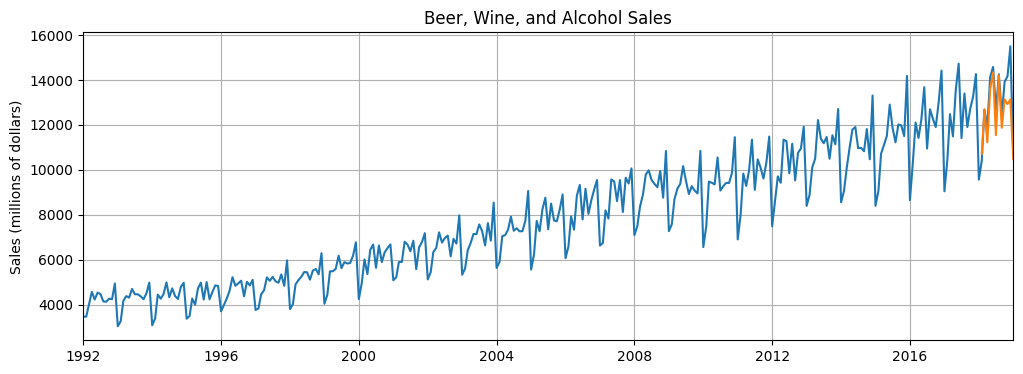

In [28]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions)
plt.show()

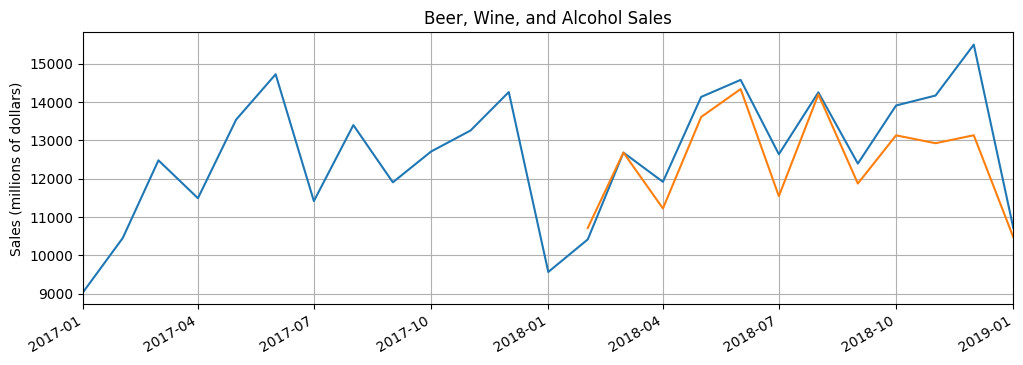

In [29]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()